<a href="https://colab.research.google.com/github/EtienneNoir/finalOne/blob/main/IthinkThisIsIt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
quadeer15sh_celeba_face_recognition_triplets_path = kagglehub.dataset_download('quadeer15sh/celeba-face-recognition-triplets')
etiennebanza_newdataset_path = kagglehub.dataset_download('etiennebanza/newdataset')
etiennebanza_faceforverification_path = kagglehub.dataset_download('etiennebanza/faceforverification')
etiennebanza_finaldatasetforthis_path = kagglehub.dataset_download('etiennebanza/finaldatasetforthis')
etiennebanza_etienne_path = kagglehub.dataset_download('etiennebanza/etienne')
etiennebanza_finalfinaldataset_path = kagglehub.dataset_download('etiennebanza/finalfinaldataset')
etiennebanza_clearrefernce_path = kagglehub.dataset_download('etiennebanza/clearrefernce')
etiennebanza_farfaces_path = kagglehub.dataset_download('etiennebanza/farfaces')

print('Data source import complete.')


<a href="https://colab.research.google.com/github/EtienneNoir/OneShot/blob/main/onshot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install keras-facenet

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


### With Transfer learning

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model, Input, layers
from tensorflow.keras.optimizers import Adam
from keras_facenet import FaceNet
from sklearn.datasets import fetch_lfw_pairs



# Loading the data into a dataframe
# so it is shuflled to ensure that data points are scattered to help the model generalize better
data = pd.read_csv("/kaggle/input/celeba-face-recognition-triplets/CelebA FR Triplets/CelebA FR Triplets/triplets.csv")
data = data.sample(frac=1).reset_index(drop=True)
 # Total samples in data = 16332

In [ ]:
data.shape

(16332, 6)

In [ ]:
# Define the root path directory for images
base_dir = '/kaggle/input/celeba-face-recognition-triplets/CelebA FR Triplets/CelebA FR Triplets/images'

# Applying a  80/20 split in the data
train = data.head(13066)
test = data.tail(3266) # reserved for validation

In [ ]:
# Creating arrays containing the full paths to the anchor, positive, and negative images
# Creating full paths for training data
train_anchor_paths = base_dir + '/' + train['anchor'].values
train_positive_paths = base_dir + '/' + train['pos'].values
train_negative_paths = base_dir + '/' + train['neg'].values

# Creating full paths for testing data
test_anchor_paths = base_dir + '/' + test['anchor'].values
test_positive_paths = base_dir + '/' + test['pos'].values
test_negative_paths = base_dir + '/' + test['neg'].values

In [ ]:
# Creating TensorFlow datasets for training
train_anchor_ds = tf.data.Dataset.from_tensor_slices(train_anchor_paths)
train_positive_ds = tf.data.Dataset.from_tensor_slices(train_positive_paths)
train_negative_ds = tf.data.Dataset.from_tensor_slices(train_negative_paths)

# Creating TensorFlow datasets for testing (validation)
test_anchor_ds = tf.data.Dataset.from_tensor_slices(test_anchor_paths)
test_positive_ds = tf.data.Dataset.from_tensor_slices(test_positive_paths)
test_negative_ds = tf.data.Dataset.from_tensor_slices(test_negative_paths)

In [ ]:
# Setting input dimension of images to meet the input size of the model
input_dimension = 160

# Function that reads files from path and resize them to 160 x 160 pixels
def loadAndPreprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)  # ensuring that the images are 3 dimensional
    image = tf.image.resize(image, (input_dimension, input_dimension))
    image = tf.image.convert_image_dtype(image, tf.float32) #  normalizing the image data
    #image = tf.image.grayscale_to_rgb ( image )
    return image

# processing the images using the above function
def preprocessTriplets(anchor_path, positive_path, negative_path):
    anchor = loadAndPreprocess_image(anchor_path)
    positive = loadAndPreprocess_image(positive_path)
    negative = loadAndPreprocess_image(negative_path)
    return (anchor, positive, negative)

In [ ]:
# Merging the three datasets to one dataset using map function
# num_parallel_calls=tf.data.AUTOTUNE is used to ensure that both datasets are created in parallel rather than sequentially
# Training triple dataset
train_dataset = tf.data.Dataset.zip((train_anchor_ds, train_positive_ds, train_negative_ds))
train_dataset = train_dataset.map(preprocessTriplets, num_parallel_calls=tf.data.AUTOTUNE)

# Testing triplet dataset
test_dataset = tf.data.Dataset.zip((test_anchor_ds, test_positive_ds, test_negative_ds))
test_dataset = test_dataset.map(preprocessTriplets, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# To satisfy the requirement of the model.fit() function that expects labels as well, a dummy triplet dataset with zero is used but will not be used
# using num_parallel_calls=tf.data.AUTOTUNE for paralellism again
def add_dummy_labels(anchor, positive, negative):
    return (anchor, positive, negative), tf.zeros((1,))

# Dummy labels for training dataset
train_dataset = train_dataset.map(add_dummy_labels, num_parallel_calls=tf.data.AUTOTUNE)

# Dummy labels for testing dataset
test_dataset = test_dataset.map(add_dummy_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
batch_size = 32

# Prepare training dataset
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Prepare testing dataset
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# This function defines a triplet loss function that helps the model differentiate between similar and dissimilar faces by learning distances between embeddings.
# Alpha is the recommended distance threshold. It controls how much farther the negative sample should be from the anchor compared to the positive sample.

"""
tf.reduce_mean(tf.maximum(basic_loss, 0.0)) is used to ensure that only triplets
where the loss is greater than zero contribute to the final loss calculation.

Allowing the model focuses on improving only the triplets where the positive is
not sufficiently closer to the anchor than the negative
"""
emb_dim = 512
alpha = 0.2

"""
Credit goes to: https://github.com/13muskanp/Siamese-Network-with-Triplet-Loss
"""
def triplet_loss(alpha=0.2, emb_dim=512):
    def loss(y_true, y_pred):
        anc = y_pred[:, :emb_dim]
        pos = y_pred[:, emb_dim:2*emb_dim]
        neg = y_pred[:, 2*emb_dim:]
        pos_distance = tf.reduce_sum(tf.square(anc - pos), axis=1)
        neg_distance = tf.reduce_sum(tf.square(anc - neg), axis=1)
        basic_loss = pos_distance - neg_distance + alpha
        return tf.reduce_mean(tf.maximum(basic_loss, 0.0))
    return loss


In [ ]:
# Load the FaceNet model
facenet = FaceNet()
embedding_model = facenet.model

# Fine tuning only the last 3 layers
for layer in embedding_model.layers[:-3]:
    layer.trainable = False

# Defining inputs for the model
anchor_input = Input(name="anchor", shape=(input_dimension, input_dimension, 3))
positive_input = Input(name="positive", shape=(input_dimension, input_dimension, 3))
negative_input = Input(name="negative", shape=(input_dimension, input_dimension, 3))

# Getting embeddings of the triplets
emb_a = embedding_model(anchor_input)
emb_p = embedding_model(positive_input)
emb_n = embedding_model(negative_input)

# Concatenating embeddings
merged_embeddings = layers.Concatenate(axis=1)([emb_a, emb_p, emb_n])

# Building the model
siamese_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_embeddings)

In [ ]:
# Compiling the model
optimizer = Adam()
siamese_network.compile(
    optimizer=optimizer,
    loss=triplet_loss(alpha=alpha, emb_dim=emb_dim),
)

# Trainning the model
epochs = 30
history = siamese_network.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset
)



Epoch 1/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 111s 172ms/step - loss: 0.2569 - val_loss: 0.1781
Epoch 2/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 38s 92ms/step - loss: 0.2048 - val_loss: 0.1740
Epoch 3/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 38s 92ms/step - loss: 0.1932 - val_loss: 0.1763
Epoch 4/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 37s 92ms/step - loss: 0.1803 - val_loss: 0.1684
Epoch 5/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - loss: 0.1797 - val_loss: 0.1697
Epoch 6/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 37s 92ms/step - loss: 0.1635 - val_loss: 0.1691
Epoch 7/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - loss: 0.1665 - val_loss: 0.1681
Epoch 8/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - loss: 0.1524 - val_loss: 0.1589
Epoch 9/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - loss: 0.1510 - val_loss: 0.1645
Epoch 10/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 38s 92ms/step - loss: 0.1460 - val_loss: 0.1527
Epoch 11/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 38s 92ms/step - loss: 0.1393 - val_loss: 0.1454
Epoch 12/30
409/409 ━━━━━━━━

In [ ]:
# Plotting the loss and accuracy during training using the history object to evaluate the progress and performance of the model during training
def plot_metrics(history):

    # The loss is used to see how well the model is minimizing the error on both the training and validation set

    plt.figure(figsize=(10, 5))

    plt.plot(history.history['loss'], label='Training Loss')

    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('Model Loss During Training')

    plt.xlabel('Epoch')

    plt.ylabel('Loss')

    plt.legend(loc='upper right')

    plt.grid(True)

    plt.show()

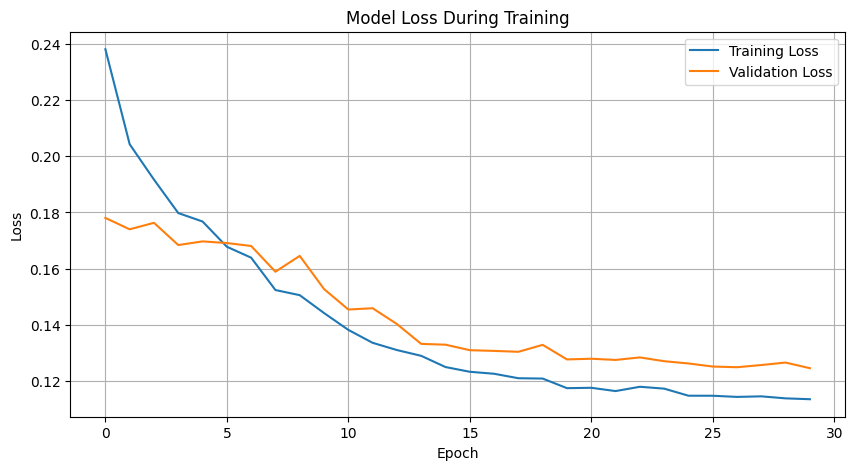

In [ ]:
plot_metrics(history)

### Testing or making predictions on the model

In [ ]:
from mtcnn import MTCNN
import cv2
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.datasets import fetch_lfw_pairs
# Loading LFW pairs dataset
lfw_pairs = fetch_lfw_pairs( color=True, resize=0.5)
from sklearn.datasets import fetch_lfw_pairs

# Fetching the training pairs
lfw_train_pairs = fetch_lfw_pairs(subset='train', color=True, resize=0.5)

# Fetching the testing pairs
lfw_test_pairs = fetch_lfw_pairs(subset='test', color=True, resize=0.5)



## Preprocessing Label faces in the Wild

The objective of the following is to use the Label Faces in the Wild dataset to analyze the distances between anchor-positive and anchor-negative pairs as calculated by a model. This will help in determining a threshold distance that can be used to classify image pairs that belong to the same person or different people.

By finding out the common distance that the model produces for identical and different pairs a threshold can be be determiend. For example once the calculated distance goes beyond a threshol then pairs are considered to be different.

In [ ]:
def preprocess_image(image, target_size=(160, 160)): # ensuring that the passed images meet the requirements of the model
    image_resized = cv2.resize(image, target_size)
    return np.expand_dims(image_resized, axis=0)

In [ ]:
# To quantify the distance
def euclideanDistance(emb1, emb2):
    return np.linalg.norm(emb1 - emb2, axis=1)

### Common distance between anchor and negative pairs by using the training pairs

In [ ]:
negatives = []
different_pairs_indices = np.where(lfw_train_pairs.target == 0)[0]  # Getting indices of different pairs

def getDistanceOfNegatives(siamese, ref, toComapre, ghost):
    emb_dim=512
    référence = ref
    nouveau = toComapre
    fantôme = ghost

    predictedEmbeddings = siamese.predict([référence, nouveau, fantôme], verbose=0)

    embréférence = predictedEmbeddings[:, :emb_dim]
    embnouveau = predictedEmbeddings[:, emb_dim:2*emb_dim]

    dist = euclideanDistance(embréférence, embnouveau)

    # Appendding the distance to the negatives list
    negatives.append(dist[0])

    return dist[0]

# looping over negative pairs

def oneShotVerificationLFW(siamese_network, emb_dim=512, alpha=0.2):

    for i in different_pairs_indices:
        ref_image = preprocess_image(lfw_train_pairs.pairs[i, 0])
        new_image = preprocess_image(lfw_train_pairs.pairs[i, 1])
        ghost_image = preprocess_image(lfw_train_pairs.pairs[i, 1])  # Placeholder as ghost image

        getDistanceOfNegatives(siamese_network, ref_image, new_image, ghost_image)


# Calling function to evaluate negative pairs
oneShotVerificationLFW(siamese_network)


### Common distance between anchor and positive pairs

In [ ]:
# Getting indices of positive pairs
positive_pairs_indices = np.where(lfw_train_pairs.target == 1)[0]
# Function to get distances for positive pairs and store them in a new list
positives = []

def getDistanceOfPositives(siamese, ref, toComapre, ghost):
    emb_dim=512
    référence = ref
    nouveau = toComapre
    fantôme = ghost

    predictedEmbeddings = siamese.predict([référence, nouveau, fantôme], verbose=0)

    embréférence = predictedEmbeddings[:, :emb_dim]
    embnouveau = predictedEmbeddings[:, emb_dim:2*emb_dim]

    dist = euclideanDistance(embréférence, embnouveau)

    # Appendding the distance to the positives list
    positives.append(dist[0])

    return dist[0]

# function to evaluate positive pairs
def evaluatePositivePairs2(siamese_network):
    for i in positive_pairs_indices:
        ref_image = preprocess_image(lfw_train_pairs.pairs[i, 0])
        new_image = preprocess_image(lfw_train_pairs.pairs[i, 1])
        ghost_image = preprocess_image(lfw_train_pairs.pairs[i, 1])  # Placeholder as ghost image

        distance = getDistanceOfPositives(siamese_network, ref_image, new_image, ghost_image)

# Calling function to evaluate positive pairs
evaluatePositivePairs2(siamese_network)


### Plotting distance range of positives

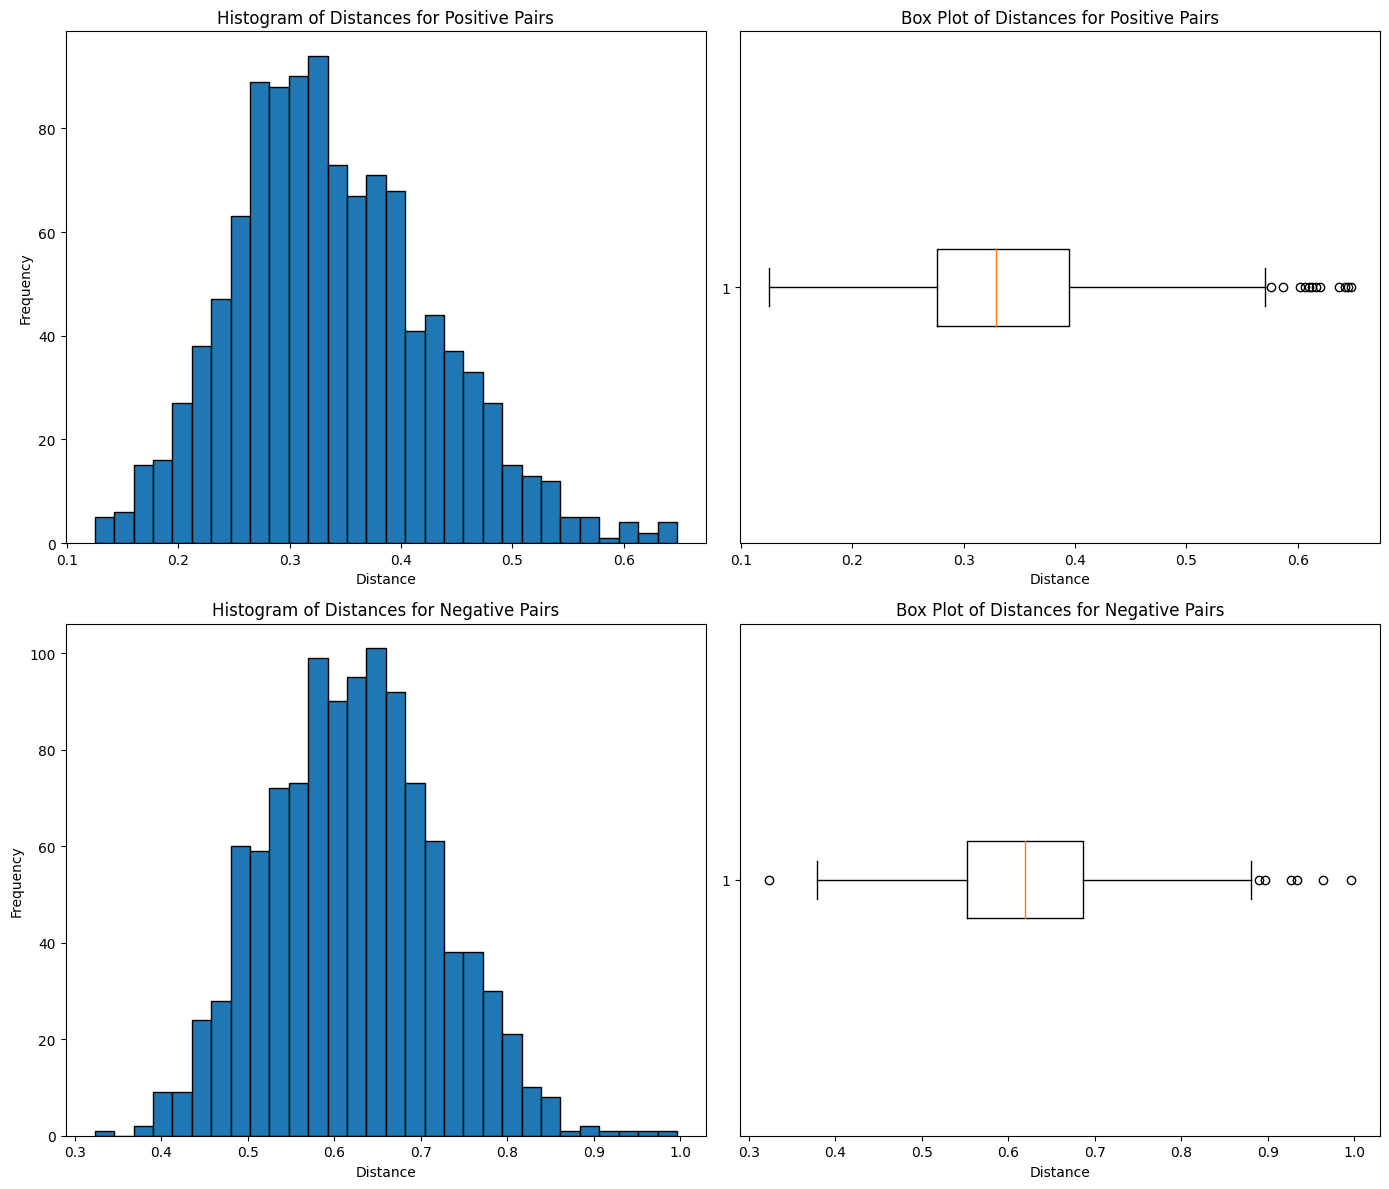

In [ ]:
plt.figure(figsize=(14, 12))

# Plotting histogram for positive pairs
plt.subplot(2, 2, 1)
plt.hist(positives, bins=30, edgecolor='black')
plt.title('Histogram of Distances for Positive Pairs')
plt.xlabel('Distance')
plt.ylabel('Frequency')

# Plotting box plot for positive pairs
plt.subplot(2, 2, 2)
plt.boxplot(positives, vert=False)
plt.title('Box Plot of Distances for Positive Pairs')
plt.xlabel('Distance')

# Plotting histogram for negative pairs
plt.subplot(2, 2, 3)
plt.hist(negatives, bins=30, edgecolor='black')
plt.title('Histogram of Distances for Negative Pairs')
plt.xlabel('Distance')
plt.ylabel('Frequency')

# Plotting box plot for negative pairs
plt.subplot(2, 2, 4)
plt.boxplot(negatives, vert=False)
plt.title('Box Plot of Distances for Negative Pairs')
plt.xlabel('Distance')

plt.tight_layout()
plt.show()


Based on the histograms and the box plots it appears that the positive distances peak around 0.3 and 0.6 for the negatives distances. Thus a threshold around 0.45 between the peak of the positive pair distances  and the peak of the negative pair distances can be used to determine whether pairs are the same or not.

In [ ]:
threshold = 0.45

Evaluating the model's ability to distinguish between images of the same person and different people by calculating the distances between their embeddings. The function outputs predictions, and stores them in the predictions list, indicating whether the images are classified as positive thus appending a value of 1 or negative with a value of 0 being appended, based on a specified distance threshold.

In [ ]:
predictions = []
def euclideanDistance(emb1, emb2):
    return np.linalg.norm(emb1 - emb2, axis=1)

def evaluate(siamese, ref, toComapre, ghost):
    emb_dim=512
    référence = ref
    nouveau = toComapre
    fantôme = ghost

    predictedEmbeddings = siamese.predict([référence, nouveau, fantôme], verbose=0)

    embréférence = predictedEmbeddings[:, :emb_dim]
    embnouveau = predictedEmbeddings[:, emb_dim:2*emb_dim]

    dist = euclideanDistance(embréférence, embnouveau)

    if dist[0] >= threshold:
        predictions.append(0)
    else:
        predictions.append(1)

def oneShotVerification(ref, nEw):
    thirdGhostImage = "/kaggle/input/newdataset/e1.jpg"
    evaluate(siamese_network, ref, nEw, thirdGhostImage)

### Evaluation on the model with all the Label Faces in the wild pairs based on the calculated threshold

In [ ]:
def oneShotVerificationLFW(siamese_network):
    for i in range(len(lfw_test_pairs.pairs)):  # evaluating all pairs not just the test pairs
        ref_image = preprocess_image(lfw_test_pairs.pairs[i, 0])
        new_image = preprocess_image(lfw_test_pairs.pairs[i, 1])
        ghost_image = preprocess_image(lfw_test_pairs.pairs[i, 1])  # Placeholder as ghost image

        evaluate(siamese_network, ref_image, new_image, ghost_image)

# Call the function to evaluate on LFW pairs
oneShotVerificationLFW(siamese_network)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# lfw_test_pairs are the true labels and predictions are the predicted labels
true_labels = lfw_test_pairs.target

# Evaluating using common metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

accuracy = accuracy * 100
precision = precision * 100
recall = recall * 100
f1 = f1 * 100
# Printing the evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f} ")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")



Evaluation Metrics:
Accuracy: 91.90 
Precision: 96.25
Recall: 87.20
F1 Score: 91.50


An accuracy 91.90% indicates model correctly classified 92.23% of all the test samples, whether they were positive thus the same person or negative denoting different people.

A precision of 96.25% means that of all the positive predictions made by the model from a pool of true positives and false positives 93.45% of the predictions were true positive 93.45% thus implying few false positive errors thus few different people were classified as the same person.

A recall of 87.20% suggests that from the pool of true positives and false negatives 90.82% were predicted to be true positves thus indicating few false negatives whic are pairs that were classified as different when they were the same.

An F1 score of 91.50% indicate that the model achieved a good balance of both recall and precision thus the model was able to  This means that the model is effective at both correctly identifying true positives and minimizing false positive and false negative errors.

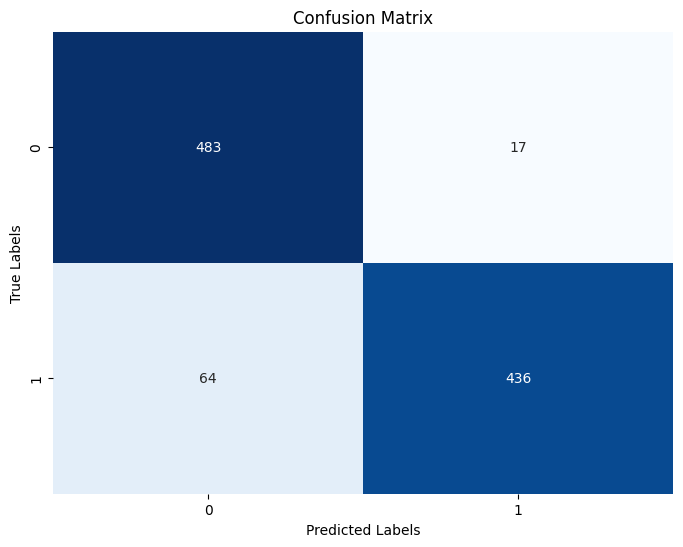

In [ ]:
# Plotting confusion matrix
def plot_confusion_matrix(true_labels, predictions):
    conf_matrix = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(true_labels, predictions)


### Final Experiment on my self and Real World Occluded Faces (ROF) dataset to evaluate how well the model is able to distinguish on other datasets that it was not trained on

In [ ]:
from mtcnn import MTCNN
import cv2
import numpy as np
import matplotlib.pyplot as plt


def detect_face_size(image_path, min_face_area_ratio=0.05):
    """Detecting faces and determines if they are too small based on area ratio."""
    # Loading and converting the image to RGB
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return False

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detector = MTCNN()

    # Detecting faces
    results = detector.detect_faces(img_rgb)
    if not results:
        print("No face detected.")
        return False

    largest_face = max(results, key=lambda res: res['box'][2] * res['box'][3])
    x, y, w, h = largest_face['box']

    # Calculating the area of the face and the total image area
    face_area = w * h
    image_area = img.shape[0] * img.shape[1]
    face_area_ratio = face_area / image_area

    print(f"Face area ratio: {face_area_ratio:.4f}")

    if face_area_ratio < min_face_area_ratio:
        print("The detected face is too small to be verified.")
        return False
    else:
        print("The detected face size is sufficient for verification.")
        return True

def detect_and_extract_face_mtcnn(image_path, target_shape=(160, 160)):
    """Detecting and extracting the largest face in the image using MTCNN."""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detector = MTCNN()
    results = detector.detect_faces(img_rgb)

    if len(results) == 0:
        print(f"No face detected in {image_path}.")
        return None

    largest_face = max(results, key=lambda res: res['box'][2] * res['box'][3])
    x, y, w, h = largest_face['box']

    x, y = max(x, 0), max(y, 0)
    face = img_rgb[y:y+h, x:x+w]

    face_resized = cv2.resize(face, target_shape) / 255.0
    return np.expand_dims(face_resized, axis=0)

def euclideanDistance(emb1, emb2):
    return np.linalg.norm(emb1 - emb2, axis=1)

def plotAnchorPositive(anchor, positive, dist_positive):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(np.squeeze(anchor))
    axes[0].set_title("Anchor")
    axes[0].axis("off")
    axes[1].imshow(np.squeeze(positive))
    axes[1].set_title(f"Positive\nDistance: {dist_positive:.4f}")
    axes[1].axis("off")
    plt.show()

def newEvaluate(siamese, ref, toComapre, ghost, emb_dim=512, alpha=0.2):
    if not detect_face_size(toComapre):
        print("Face is too small for verification please move closer to the camera.")

        return

    référence = detect_and_extract_face_mtcnn(ref)
    nouveau = detect_and_extract_face_mtcnn(toComapre)
    fantôme = detect_and_extract_face_mtcnn(ghost)

    if référence is None or nouveau is None or fantôme is None:
        print("One or more images failed to process.")
        return

    predictedEmbeddings = siamese.predict([référence, nouveau, fantôme], verbose=0)

    embréférence = predictedEmbeddings[:, :emb_dim]
    embnouveau = predictedEmbeddings[:, emb_dim:2*emb_dim]

    dist = euclideanDistance(embréférence, embnouveau)
    plotAnchorPositive(référence[0], nouveau[0], dist[0])

    print(f"Distance between the reference and presented image: {dist[0]:.4f}")
    if dist[0] >= threshold: # call the decided threshold
        print("Different Individuals - Access denied.")
    else:
        print("Same Person - Access granted!!")

def oneShotVerification(ref, nEw):
    thirdGhostImage = "/kaggle/input/newdataset/e1.jpg"
    newEvaluate(siamese_network, ref, nEw, thirdGhostImage, emb_dim=512, alpha=0.2)

Face area ratio: 0.1343
The detected face size is sufficient for verification.


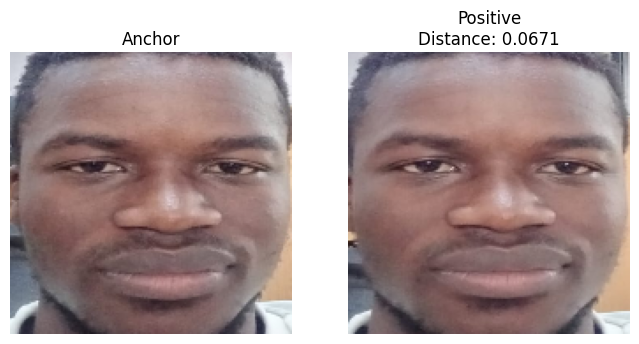

Distance between the reference and presented image: 0.0671
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/clearrefernce/f2.jpg"

imageToVerifify = "/kaggle/input/clearrefernce/fe1.jpg"

oneShotVerification(accountOf , imageToVerifify)

Face area ratio: 0.3131
The detected face size is sufficient for verification.


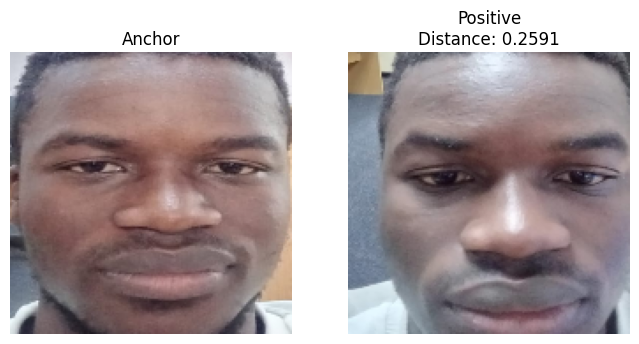

Distance between the reference and presented image: 0.2591
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/clearrefernce/f2.jpg"

imageToVerifify = "/kaggle/input/etienne/IMG-20241017-WA0006.jpg"

oneShotVerification(accountOf , imageToVerifify)

Face area ratio: 0.1517
The detected face size is sufficient for verification.


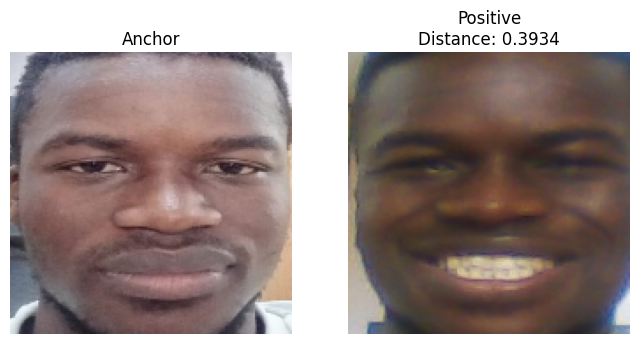

Distance between the reference and presented image: 0.3934
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/clearrefernce/f2.jpg"

imageToVerifify = "/kaggle/input/newdataset/e2.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.1793
The detected face size is sufficient for verification.


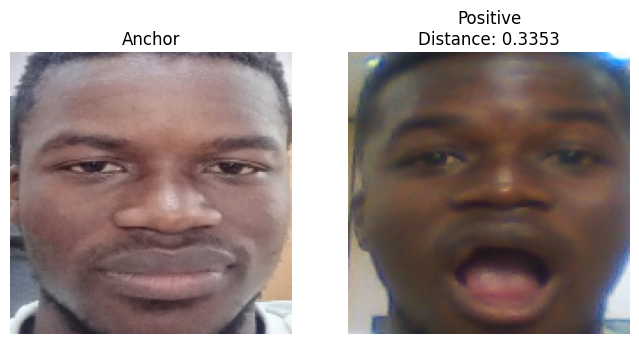

Distance between the reference and presented image: 0.3353
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/clearrefernce/f2.jpg"

imageToVerifify = "/kaggle/input/newdataset/e4.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.1517
The detected face size is sufficient for verification.


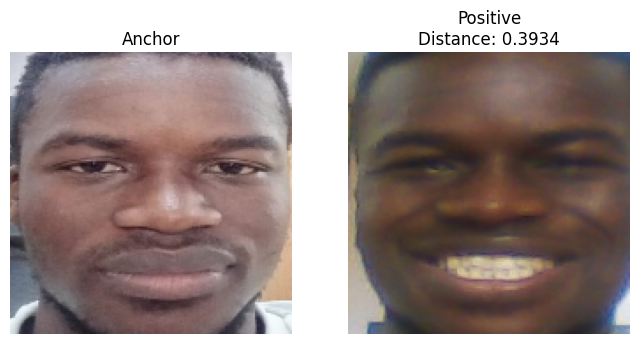

Distance between the reference and presented image: 0.3934
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/clearrefernce/f2.jpg"

imageToVerifify = "/kaggle/input/newdataset/e2.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.1517
The detected face size is sufficient for verification.


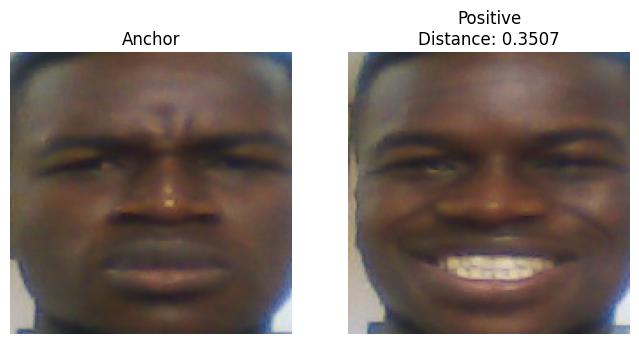

Distance between the reference and presented image: 0.3507
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/newdataset/e5.jpg"

imageToVerifify = "/kaggle/input/newdataset/e2.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.1793
The detected face size is sufficient for verification.


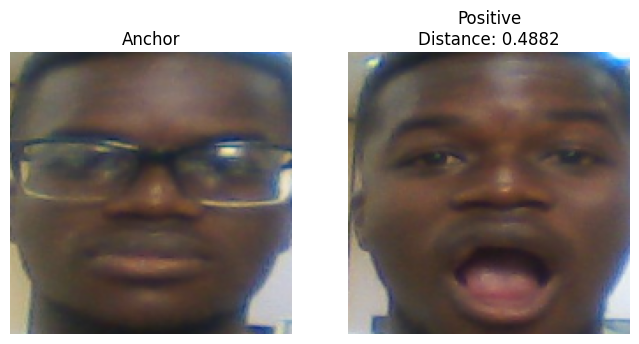

Distance between the reference and presented image: 0.4882
Different Individuals - Access denied.


In [ ]:
accountOf = "/kaggle/input/newdataset/e1.jpg"

imageToVerifify = "/kaggle/input/newdataset/e4.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.3131
The detected face size is sufficient for verification.


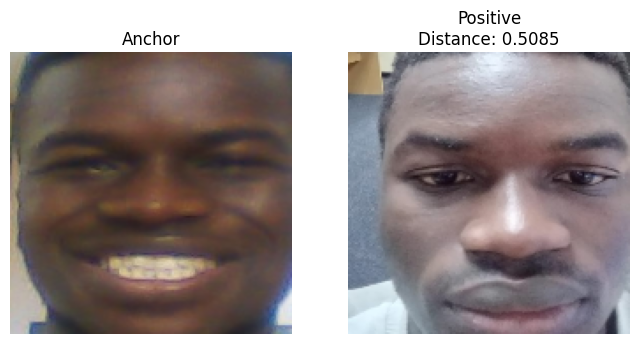

Distance between the reference and presented image: 0.5085
Different Individuals - Access denied.


In [ ]:
accountOf = "/kaggle/input/newdataset/e2.jpg"

imageToVerifify = "/kaggle/input/etienne/IMG-20241017-WA0006.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.1473
The detected face size is sufficient for verification.


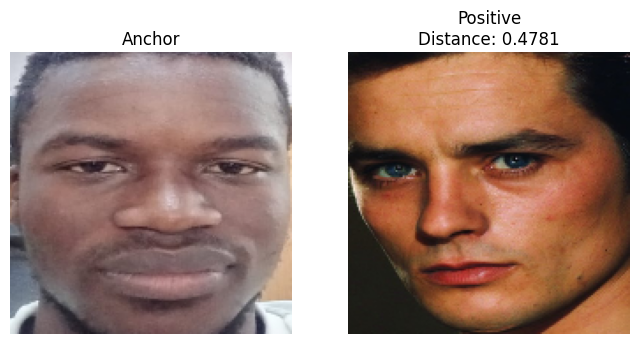

Distance between the reference and presented image: 0.4781
Different Individuals - Access denied.


In [ ]:
accountOf = "/kaggle/input/clearrefernce/f2.jpg"

imageToVerifify = "/kaggle/input/finaldatasetforthis/delon_2.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.2087
The detected face size is sufficient for verification.


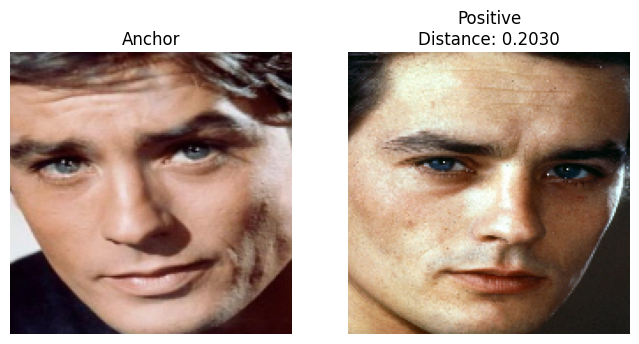

Distance between the reference and presented image: 0.2030
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/delon_3.webp"

imageToVerifify = "/kaggle/input/finaldatasetforthis/delon_4.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.1473
The detected face size is sufficient for verification.


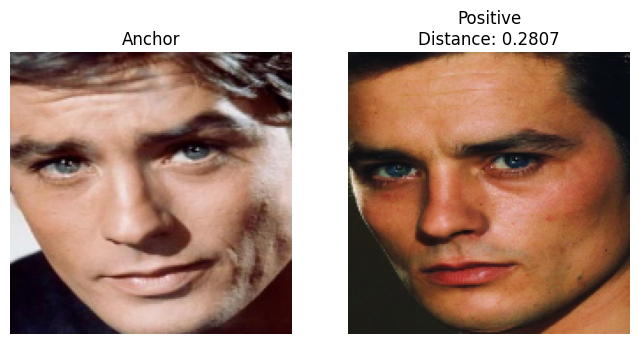

Distance between the reference and presented image: 0.2807
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/delon_3.webp"

imageToVerifify = "/kaggle/input/finaldatasetforthis/delon_2.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.1473
The detected face size is sufficient for verification.


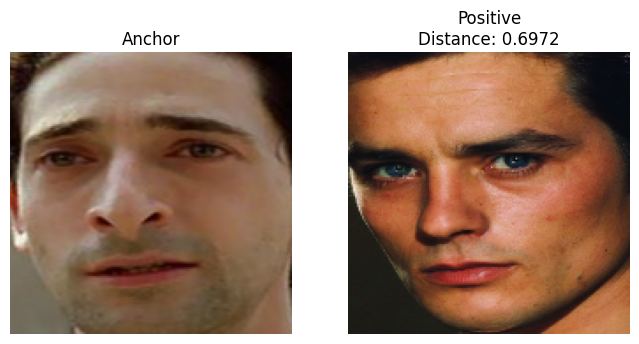

Distance between the reference and presented image: 0.6972
Different Individuals - Access denied.


In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/finaldatasetforthis/delon_2.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.2215
The detected face size is sufficient for verification.


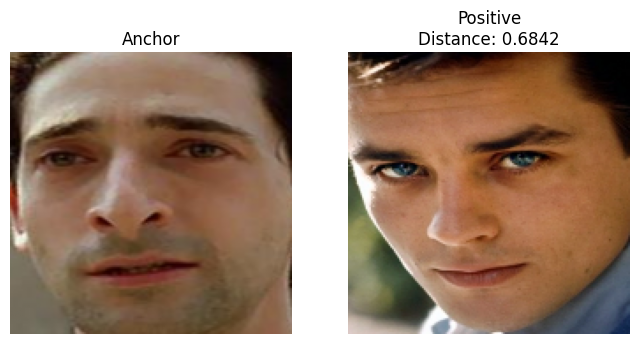

Distance between the reference and presented image: 0.6842
Different Individuals - Access denied.


In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/finaldatasetforthis/delon_1.webp"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.1108
The detected face size is sufficient for verification.


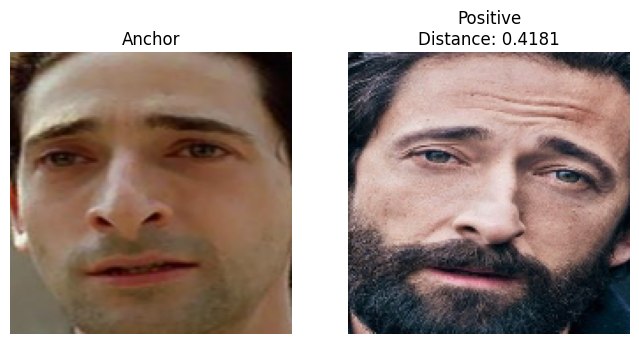

Distance between the reference and presented image: 0.4181
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/finaldatasetforthis/adrien_brody_3.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.1792
The detected face size is sufficient for verification.


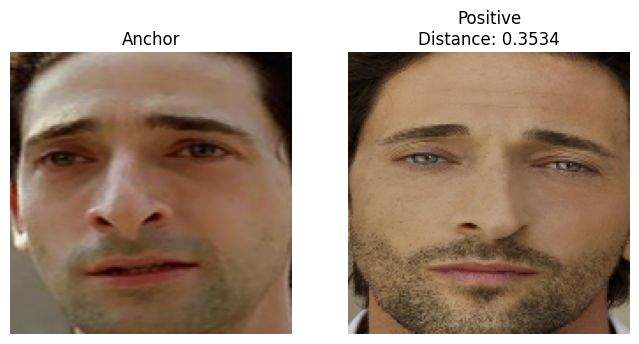

Distance between the reference and presented image: 0.3534
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/finaldatasetforthis/adrien_brody_2.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.2300
The detected face size is sufficient for verification.


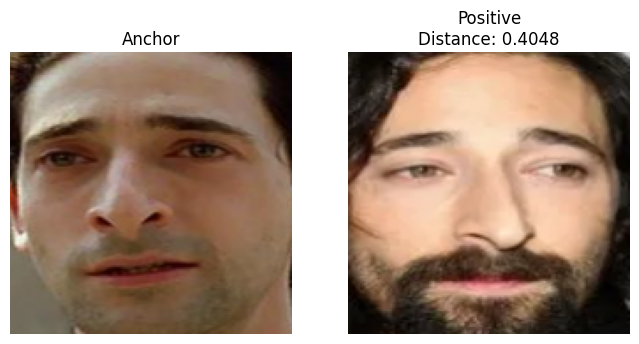

Distance between the reference and presented image: 0.4048
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/finaldatasetforthis/adrien_brody_1.webp"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.1290
The detected face size is sufficient for verification.


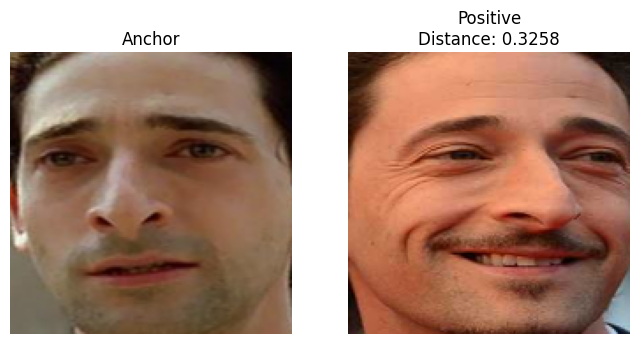

Distance between the reference and presented image: 0.3258
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/finaldatasetforthis/adrien-brody_6.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.2459
The detected face size is sufficient for verification.


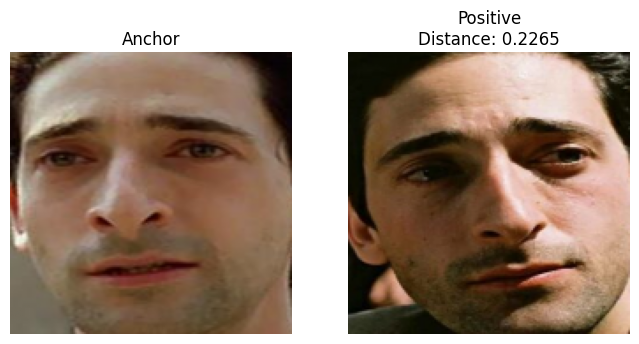

Distance between the reference and presented image: 0.2265
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/finaldatasetforthis/adrien-brody_5.jpg"

oneShotVerification(accountOf , imageToVerifify )

#### Faces that are too far from the camera

In [ ]:
# function to display the images that have their faces too far to be verified, simulating what would happen if this model was to be implemented at an ATM
def plot_images(path):

    img = cv2.imread(path)

    if img is None:
        print("One or both images could not be loaded.")
        return

    # Converting from BGR to RGB for plotting
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    # Plotting the images
    fig, axes = plt.subplots(1,figsize=(10, 5))
    axes.imshow(img_rgb)
    axes.set_title("Image to Verify")
    axes.axis("off")

Face area ratio: 0.0053
The detected face is too small to be verified.
Face is too small for verification please move closer to the camera.


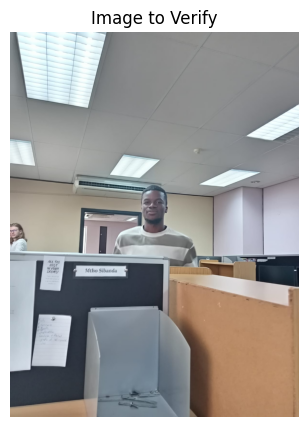

In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/farfaces/f1.jpg"

oneShotVerification(accountOf , imageToVerifify )

plot_images(imageToVerifify)

Face area ratio: 0.0150
The detected face is too small to be verified.
Face is too small for verification please move closer to the camera.


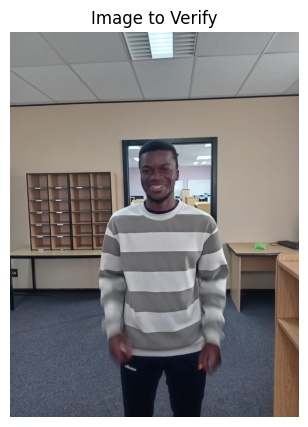

In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/farfaces/f2.jpg"

oneShotVerification(accountOf , imageToVerifify )

plot_images(imageToVerifify)

Face area ratio: 0.0140
The detected face is too small to be verified.
Face is too small for verification please move closer to the camera.


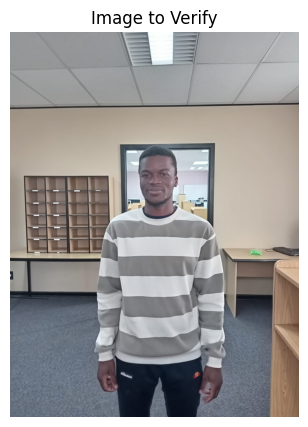

In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/farfaces/f3.jpg"

oneShotVerification(accountOf , imageToVerifify )

plot_images(imageToVerifify)

In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/farfaces/f4.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.0046
The detected face is too small to be verified.
Face is too small for verification please move closer to the camera.
